<a href="https://colab.research.google.com/github/devadathprabhu/DSC612/blob/main/TheoryAssignment_Model1_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

In [3]:
%cd /content/gdrive/MyDrive/Kaggle

/content/gdrive/MyDrive/Kaggle


In [5]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

100% 711M/714M [00:16<00:00, 33.8MB/s]
100% 714M/714M [00:16<00:00, 46.4MB/s]


In [6]:
!unzip \*.zip  && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_13.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_1

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from skimage import io
import cv2
import random

import tensorflow as tf
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import add
from keras.layers import Activation
from keras.layers import UpSampling2D
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Lambda
from keras.layers import multiply
from keras.layers import concatenate

from tensorflow.keras import backend as K
from tensorflow.keras.metrics import MeanIoU
from sklearn.model_selection import train_test_split

In [8]:
path = "/content/gdrive/MyDrive/Kaggle/lgg-mri-segmentation/kaggle_3m/"
df = pd.read_csv(path + "data.csv")
df.head()

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0


In [9]:
masks_dir = glob(path + "*/*_mask*")

images_dir = []
for img in masks_dir:
    images_dir.append(img.replace("_mask", ""))

In [10]:
data_brain = pd.DataFrame(data={
                                "file_images":images_dir, 
                                "file_masks":masks_dir
                                })
data_brain.head()

,file_images,file_masks
0,/content/gdrive/MyDrive/Kaggle/lgg-mri-segment...,/content/gdrive/MyDrive/Kaggle/lgg-mri-segment...
1,/content/gdrive/MyDrive/Kaggle/lgg-mri-segment...,/content/gdrive/MyDrive/Kaggle/lgg-mri-segment...
2,/content/gdrive/MyDrive/Kaggle/lgg-mri-segment...,/content/gdrive/MyDrive/Kaggle/lgg-mri-segment...
3,/content/gdrive/MyDrive/Kaggle/lgg-mri-segment...,/content/gdrive/MyDrive/Kaggle/lgg-mri-segment...
4,/content/gdrive/MyDrive/Kaggle/lgg-mri-segment...,/content/gdrive/MyDrive/Kaggle/lgg-mri-segment...


In [11]:
def positive_negative_diagnosis(file_masks):
    mask = cv2.imread(file_masks)
    value = np.max(mask)
    if value > 0:
        return 1
    else:
        return 0

In [12]:
data_brain["mask"] = data_brain["file_masks"].apply(
    lambda x: positive_negative_diagnosis(x))

In [27]:
data_brain['mask'] = data_brain['mask'].apply(lambda x: str(x))
data_brain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   file_images  3929 non-null   object
 1   file_masks   3929 non-null   object
 2   mask         3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [28]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data_brain, test_size = 0.15)

In [29]:
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)

train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='file_images',
y_col='mask',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='file_images',
y_col='mask',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# Create a data generator for test images
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='file_images',
y_col='mask',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))

Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [46]:
from tensorflow.keras.applications.resnet50 import ResNet50
basemodel = ResNet50(weights = 'imagenet', include_top = False,
                     input_tensor = Input(shape=(256, 256, 3)))
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [48]:
for layer in basemodel.layers:
  layer.trainable = False

In [53]:
headmodel = basemodel.output
headmodel = tf.keras.layers.AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = tf.keras.layers.Flatten(name= 'flatten')(headmodel)
headmodel = tf.keras.layers.Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = tf.keras.layers.Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = tf.keras.layers.Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = tf.keras.layers.Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [54]:
model.compile(loss='categorical_crossentropy',optimizer='adam',
              metrics=["accuracy"])

In [55]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
earlystopping =EarlyStopping(monitor='val_loss',
                             mode='min', verbose=1,
                             patience=20)

# save the model with least validation loss
checkpointer = ModelCheckpoint(filepath="classifier-resnet-weights.hdf5",
                               verbose=1, save_best_only=True)

In [65]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 32,
                    epochs = 10, validation_data= valid_generator, 
                    validation_steps= valid_generator.n // 32,
                    callbacks=[checkpointer, earlystopping])

Epoch 1/10
88/88 [==============================] - ETA: 0s - loss: 0.6476 - accuracy: 0.6505
Epoch 00001: val_loss did not improve from 0.60111
88/88 [==============================] - 380s 4s/step - loss: 0.6476 - accuracy: 0.6505 - val_loss: 0.6361 - val_accuracy: 0.6673
Epoch 2/10
88/88 [==============================] - ETA: 0s - loss: 0.6486 - accuracy: 0.6526
Epoch 00002: val_loss did not improve from 0.60111
88/88 [==============================] - 379s 4s/step - loss: 0.6486 - accuracy: 0.6526 - val_loss: 0.6391 - val_accuracy: 0.6653
Epoch 3/10
88/88 [==============================] - ETA: 0s - loss: 0.6493 - accuracy: 0.6490
Epoch 00003: val_loss did not improve from 0.60111
88/88 [==============================] - 378s 4s/step - loss: 0.6493 - accuracy: 0.6490 - val_loss: 0.6342 - val_accuracy: 0.6714
Epoch 4/10
88/88 [==============================] - ETA: 0s - loss: 0.6481 - accuracy: 0.6526
Epoch 00004: val_loss did not improve from 0.60111
88/88 [=======================

In [66]:
def summarize_diagnostics(history):
  # plot loss
  plt.subplot(211)
  plt.title('Cross Entropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='test')
  # plot accuracy
  plt.subplot(212)
  plt.title('Classification Accuracy')
  plt.plot(history.history['accuracy'], color='blue', label='train')
  plt.plot(history.history['val_accuracy'], color='orange', label='test')
  plt.show()

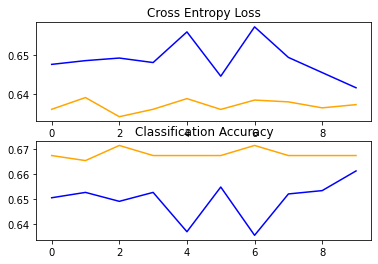

In [74]:
summarize_diagnostics(history)